In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
import math
import numpy as np


## Setting up training with CIFAR-10

IGNORE: Please ignore, this as I switched to 3-layer MLP to directly import code for muP.



We will first setup a base training pipeline for training a 2 layer network. We will focus on training only for one-epoch and try to optimize our loss for this. 

### Forward Pass
$x_1 = \sigma(W_1 \cdot x_{in} + b_1); x_{in} \in \mathbb{R}^{n}; W_1 \in \mathbb{R}^{h \times n}; b_1 \in \mathbb{R}^h$
$y = W_2 \cdot x_1 + b_2$

Compute per image:
For Layer 1: $2 * h * x_{in} + h - 1$

For the GELU activation fn: I assume its $5*h$ (Compute for such operations is difficult and dependent on the implementation; But in the grand scheme of things they shouldn't matter)

For Layer 2: $2 * n_{classes} * h + n_{classes} - 1$

So for the forward pass = $2 * (n_{classes} + 3 + x_{in}) * h + n_{classes} - 2$

We can just assume a 2:1 Backward to Forward ratio. 

### Backward Pass

$\frac{\delta L}{W_2[i,j]} = \frac{\delta L}{y} * x_j$

$\frac{\delta L}{x_1[j]} = \frac{\delta L}{y} * W_2[:,j]$

$\frac{\delta L}{W_1[i;j]} = \frac{\delta L}{x_1[i]}[j] * $ // Ignoring derivative computation through the gelu function

In [2]:
def get_steps(compute, batch_size, input_size, n_classes, hidden_size):
    compute_per_example = 6 * (n_classes + 3 + input_size) * hidden_size + n_classes - 2
    compute_per_step = batch_size * compute_per_example
    
    return math.ceil(compute / compute_per_step)

def get_compute(steps, batch_size, input_size, n_classes, hidden_size):
    compute_per_example = 6 * (n_classes + 3 + input_size) * hidden_size + n_classes - 2
    compute_per_step = batch_size * compute_per_example
    
    return compute_per_step * steps

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size=3*32*32, width=128, num_classes=10, nonlin=nn.functional.gelu, output_mult=1.0, input_mult=1.0):
        super(MLP, self).__init__()
        self.nonlin = nonlin
        self.input_mult = input_mult
        self.output_mult = output_mult
        self.fc_1 = nn.Linear(input_size, width, bias=False)
        self.fc_2 = nn.Linear(width, width, bias=False)
        self.fc_3 = nn.Linear(width, num_classes, bias=False)
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.kaiming_normal_(self.fc_1.weight, a=1, mode='fan_in')
        self.fc_1.weight.data /= self.input_mult**0.5
        nn.init.kaiming_normal_(self.fc_2.weight, a=1, mode='fan_in')
        nn.init.zeros_(self.fc_3.weight)

    def forward(self, x):
        average_l1 = []
        
        out = self.nonlin(self.fc_1(x) * self.input_mult**0.5)
        average_l1.append(out.abs().mean().item())
        
        out = self.nonlin(self.fc_2(out))
        average_l1.append(out.abs().mean().item())
        
        out = self.fc_3(out) * self.output_mult
        average_l1.append(out.abs().mean().item())
        
        return out, average_l1
    
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
class WarmupCosineAnnealingLR(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_steps, total_steps, eta_min=0, last_step=-1):
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.eta_min = eta_min

        # Create internal schedulers
        self.warmup_scheduler = lr_scheduler.LinearLR(
            optimizer, start_factor=0.01, total_iters=warmup_steps
        )
        self.cosine_scheduler = lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=total_steps - warmup_steps, eta_min=eta_min
        )

        super(WarmupCosineAnnealingLR, self).__init__(optimizer, last_step)

    def get_lr(self):
        if self.last_epoch < self.warmup_steps:
            return self.warmup_scheduler.get_lr()
        else:
            # Ensure that the cosine annealing starts after warmup
            self.cosine_scheduler.last_epoch = self.last_epoch - self.warmup_steps
            return self.cosine_scheduler.get_lr()

    def step(self, step=None):
        if step is None:
            step = self.last_epoch + 1
        self.last_epoch = step
        if step < self.warmup_steps:
            self.warmup_scheduler.step(step)
        else:
            self.cosine_scheduler.step(step - self.warmup_steps)

In [5]:
def train(
    input_size: int = 32 * 32 * 3,
    width: int = 100,
    num_classes: int = 10,
    batch_size: int = 64,
    peak_lr: float = 0.001,
    total_steps: int = 10000,
    scheduler_type: str = '',
):
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model
    model = MLP(input_size=input_size, width=width, num_classes=num_classes).to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=peak_lr)
    
    if scheduler_type: 
        if scheduler_type == 'warmup_cosine':
            scheduler = WarmupCosineAnnealingLR(optimizer, warmup_steps=int(0.1 * total_steps), total_steps=total_steps)
        elif scheduler_type == 'linear_decay':
            scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.01, total_iters=total_steps)
        else:
            raise ValueError(f"Scheduler not supported: {scheduler_type}")

    losses = []

    # Training loop
    step = 0
    avg_l1_steps = []
    while step <= total_steps:
        for images, labels in train_loader:
            step += 1
             
            images = images.reshape(-1, input_size).to(device)
            labels = labels.to(device)

            # Forward pass
            outputs, avg_l1 = model(images)
            
            avg_l1_steps.append(avg_l1)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler_type: scheduler.step()
            losses.append(loss.item())
            
            if step > total_steps:
                break
            
            # if (i + 1) % 100 == 0:
            #     print(f'Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')
            
    # Test the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.reshape(-1, input_size).to(device)
            labels = labels.to(device)
            outputs, avg_l1 = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return losses, correct / total, avg_l1_steps

/home/prnaidu/miniconda3/envs/mup/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/prnaidu/miniconda3/envs/mup/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unab

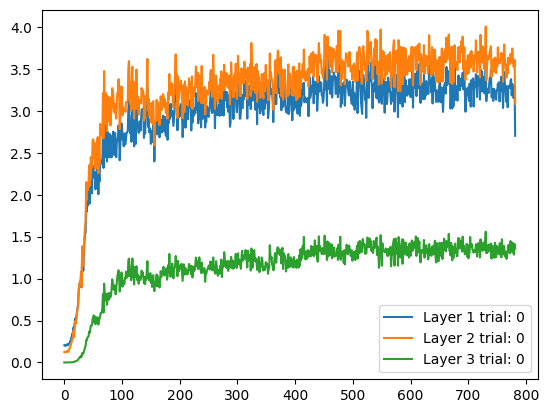

(32, 0.001, 64, 'warmup_cosine') 1.858376383781433 0.4189


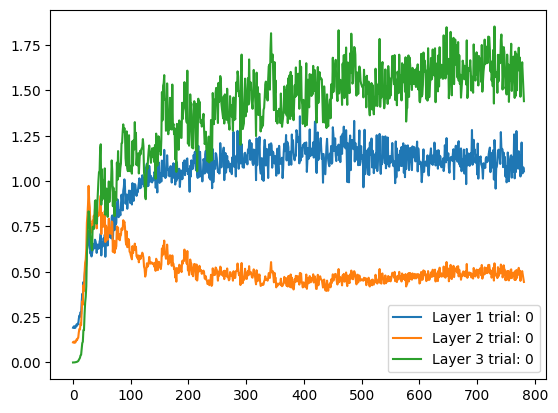

(512, 0.001, 64, 'warmup_cosine') 1.2293082475662231 0.5001


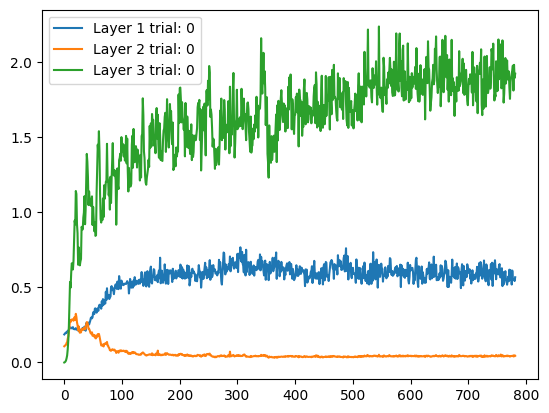

(8192, 0.001, 64, 'warmup_cosine') 1.8159029483795166 0.5181


In [7]:
input_size = 3 * 32 * 32
# hidden_size = 1536
num_classes = 10
num_epochs = 10
# batch_size = 128

num_trials = 1

for batch_size in [64]:
    for lr in [1e-3]: # [1e-1, 1e-2, 1e-3, 1e-4]:
        for width in [32, 512, 8192]:
            for scheduler_type in ['warmup_cosine']:
                avg_losses, avg_test_acc = 0, 0
                for trial_id in range(num_trials):
                    losses, test_acc, avg_l1_steps = train( 
                        total_steps=50000 // batch_size,  
                        peak_lr=lr, 
                        width=width,
                        batch_size=batch_size, 
                        num_classes=num_classes,
                        scheduler_type=scheduler_type)
                    
                    avg_losses += losses[-1] / num_trials
                    avg_test_acc += test_acc / num_trials
                    
                    avg_l1_steps = np.array(avg_l1_steps)

                    # plt.plot(losses)
                    # plt.show()
                    
                    plt.plot(avg_l1_steps[:, 0], label=f'Layer 1 trial: {trial_id}')
                    plt.plot(avg_l1_steps[:, 1], label=f'Layer 2 trial: {trial_id}')
                    plt.plot(avg_l1_steps[:, 2], label=f'Layer 3 trial: {trial_id}')
                
                # plt.yscale('log')
                plt.legend()
                plt.show()
                    
                print((width, lr, batch_size, scheduler_type), avg_losses, avg_test_acc)
            

In [17]:
from mup import MuAdamW, get_shapes, set_base_shapes, make_base_shapes, MuReadout
from mup.init import kaiming_normal_

class muMLP(nn.Module):
    def __init__(self, input_size=3*32*32, width=128, num_classes=10, nonlin=nn.functional.gelu, output_mult=1.0, input_mult=1.0):
        super(muMLP, self).__init__()
        self.nonlin = nonlin
        self.input_mult = input_mult
        self.output_mult = output_mult
        self.fc_1 = nn.Linear(input_size, width, bias=False)
        self.fc_2 = nn.Linear(width, width, bias=False)
        self.fc_3 = MuReadout(width, num_classes, bias=False, output_mult=self.output_mult)
        self.reset_parameters()
    
    # def reset_parameters(self):
    #     kaiming_normal_(self.fc_1.weight, a=1, mode='fan_in')
    #     self.fc_1.weight.data /= self.input_mult**0.5
    #     kaiming_normal_(self.fc_2.weight, a=1, mode='fan_in')
    #     nn.init.zeros_(self.fc_3.weight)
    
    def reset_parameters(self):
        nn.init.kaiming_normal_(self.fc_1.weight, a=1, mode='fan_in')
        self.fc_1.weight.data /= self.input_mult**0.5
        nn.init.kaiming_normal_(self.fc_2.weight, a=1, mode='fan_in')
        nn.init.zeros_(self.fc_3.weight)

    def forward(self, x):
        average_l1 = []
        
        out = self.nonlin(self.fc_1(x) * self.input_mult**0.5)
        average_l1.append(out.abs().mean().item())
        
        out = self.nonlin(self.fc_2(out))
        average_l1.append(out.abs().mean().item())
        
        out = self.fc_3(out) * self.output_mult
        average_l1.append(out.abs().mean().item())
        
        return out, average_l1

In [18]:
def mup_train(
    total_steps: int = 300,
    input_size: int = 32 * 32 * 3,
    width: int = 100,
    num_classes: int = 10,
    batch_size: int = 64,
    peak_lr: float = 0.001,
    scheduler_type: str = '',
):
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model
    base_model = muMLP(input_size=input_size, width=1, num_classes=num_classes)
    delta_model = muMLP(input_size=input_size, width=2, num_classes=num_classes)
    
    model = muMLP(input_size=input_size, width=width, num_classes=num_classes).to(device)
    
    set_base_shapes(model, base_model, delta=delta_model)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = MuAdamW(model.parameters(), lr=peak_lr)
    
    if scheduler_type: 
        if scheduler_type == 'warmup_cosine':
            scheduler = WarmupCosineAnnealingLR(optimizer, warmup_steps=int(0.1 * total_steps), total_steps=total_steps)
        elif scheduler_type == 'linear_decay':
            scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.01, total_iters=total_steps)
        else:
            raise ValueError(f"Scheduler not supported: {scheduler_type}")

    losses = []

    # Training loop
    step = 0
    avg_l1_steps = []
    while step <= total_steps:
        for images, labels in train_loader:
            step += 1
             
            images = images.reshape(-1, input_size).to(device)
            labels = labels.to(device)

            # Forward pass
            outputs, avg_l1 = model(images)
            
            avg_l1_steps.append(avg_l1)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler_type: scheduler.step()
            losses.append(loss.item())
            
            if step > total_steps:
                break
            
            # if (i + 1) % 100 == 0:
            #     print(f'Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')
            
    # Test the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.reshape(-1, input_size).to(device)
            labels = labels.to(device)
            outputs, avg_l1 = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return losses, correct / total, avg_l1_steps

/home/prnaidu/miniconda3/envs/mup/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/prnaidu/miniconda3/envs/mup/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unab

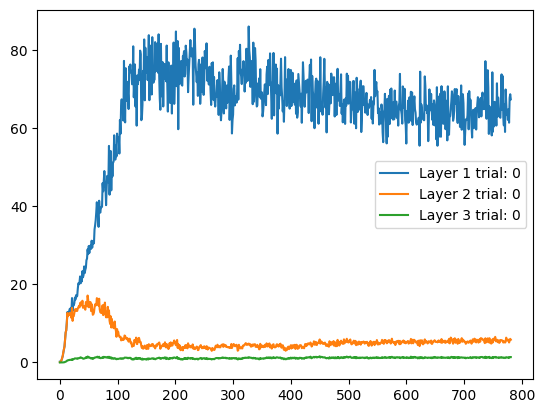

(32, 0.1, 64, 'warmup_cosine') 1.7238061428070068 0.4139


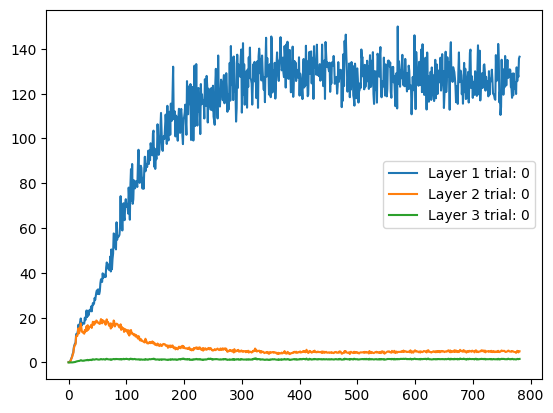

(512, 0.1, 64, 'warmup_cosine') 1.6558117866516113 0.4731


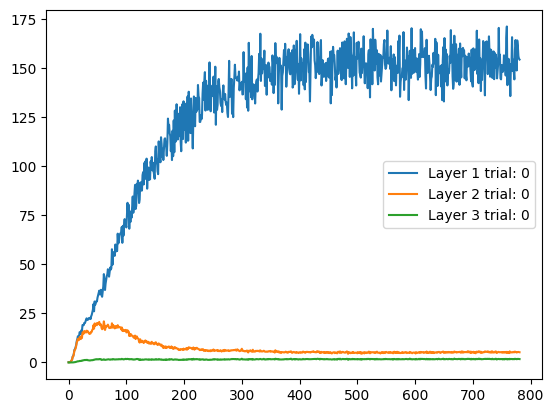

(8192, 0.1, 64, 'warmup_cosine') 1.1713182926177979 0.5052


In [19]:
input_size = 3 * 32 * 32
# hidden_size = 1536
num_classes = 10
num_epochs = 10
# batch_size = 128

num_trials = 1

for batch_size in [64]:
    for lr in [1e-1]: # [1e-1, 1e-2, 1e-3, 1e-4]:
        for width in [32, 512, 8192]:
            for scheduler_type in ['warmup_cosine']:
                avg_losses, avg_test_acc = 0, 0
                for trial_id in range(num_trials):
                    losses, test_acc, avg_l1_steps = mup_train( 
                        total_steps=50000 // batch_size,  
                        peak_lr=lr, 
                        width=width,
                        batch_size=batch_size, 
                        num_classes=num_classes,
                        scheduler_type=scheduler_type)
                    
                    avg_losses += losses[-1] / num_trials
                    avg_test_acc += test_acc / num_trials
                    
                    avg_l1_steps = np.array(avg_l1_steps)

                    # plt.plot(losses)
                    # plt.show()
                    
                    plt.plot(avg_l1_steps[:, 0], label=f'Layer 1 trial: {trial_id}')
                    plt.plot(avg_l1_steps[:, 1], label=f'Layer 2 trial: {trial_id}')
                    plt.plot(avg_l1_steps[:, 2], label=f'Layer 3 trial: {trial_id}')
                
                # plt.yscale('log')
                plt.legend()
                plt.show()
                    
                print((width, lr, batch_size, scheduler_type), avg_losses, avg_test_acc)
            